In [1]:
# Deep learning framework
import keras
print(keras.__version__)
# Implements TensorFlow on GPU (hence older version)
import tensorflow as tf
print(tf.__version__)
# Data importing
import pandas as pd
print(pd.__version__)
# Matrix and numerical functions
import numpy as np
print(np.__version__)
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Serializing objects
import pickle
# Serializing trained models
import h5py
# Printing readable results
from prettytable import PrettyTable

# Various Keras tools
from keras.models import Model, Sequential, model_from_json
from keras import layers, regularizers, Input, Model, callbacks
from keras.optimizers import RMSprop, Adam, Nadam
from keras.utils import plot_model
# Have to use K.clear_session() for TensorBoard to work
from keras import backend as K

Using TensorFlow backend.


2.1.3
1.1.0
0.22.0
1.12.1


## Import helper functions

In [2]:
from functions import generator

In [3]:
# Use seaborn graphical settings, which are much prettier
sns.set()
# Scale widths, fonts, etc. to fit well in a paper (an alternative would be "notebook")
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

### Train/validation/test data standardized by training data parameters

In [4]:
# Load prepared csv's from data_intake
df2n = np.loadtxt('data/standardized_complete.csv', delimiter = ',', skiprows = 1)
df2n_train = np.loadtxt('data/standardized_train.csv', delimiter = ',', skiprows = 1)
df2n_valid = np.loadtxt('data/standardized_valid.csv', delimiter = ',', skiprows = 1)
df2n_test = np.loadtxt('data/standardized_test.csv', delimiter = ',', skiprows = 1)

train_size = df2n_train.shape[0]
valid_size = df2n_valid.shape[0]
test_size = df2n_test.shape[0]

print(df2n.shape)
print(df2n_train.shape)
print(df2n_valid.shape)
print(df2n_test.shape)

# Load helper metadata
headers = pickle.load(open('Data/headers', 'rb'))
means = pickle.load(open('Data/means', 'rb'))
stdevs = pickle.load(open('Data/stdevs', 'rb'))

(53400, 329)
(35880, 329)
(8760, 329)
(8760, 329)


## Function to evaluate an architecture
Parameters (in order):
- Function to generate models
- Input layer tensor object
- k number of models to generate and evaluate
- Number of epochs
- ce_k number of checkpoints to use for checkpoint ensembling
- Plotting y axis limits (low, high) --> from experimentation
- Folder path to store objects of the models. Numbered sub-folders must alreday exist.
- Training set generator and number of steps
- Validation (test) set generator and numbers of steps
- Vector of variable standard deviations (from when the training set was standardized)

Returns:
- The k trained models
- The corresponding k training histories
- Lists of the MAEs, RMSEs, and Checkpoint Ensembled MAEs and RMSEs for each model

In [5]:
def load_model(model_function, input_layer, sorted_epoch_num, path, modelnum):
    if(sorted_epoch_num < 10):
        epoch = '0'+str(sorted_epoch_num)
    else:
        epoch = str(sorted_epoch_num)
    
    loaded_model = model_function(input_layer)
    loaded_model.load_weights(path+modelnum+'/weights_'+epoch+'.h5')
    return loaded_model

def evaluate_mlp(model_function, input_layer, train_gen, train_steps, stdevs, val_gen, val_steps,
                 test_gen, test_steps, path, k = 5, epochs = 100, ce_k = 5, ylim = (1.5, 4)):
    models = []
    histories = []
    val_maes = []
    val_rmses = []
    val_ce_maes = []
    val_ce_rmses = []
    val_ranked_epochs = []
    test_ce_maes = []
    test_ce_rmses = []
    
    
    for i in range(k):
        print('\nTraining model #', str(i+1))
        model = model_function(input_layer)
        model.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
        
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath = path+str(i+1)+'/weights_{epoch:02d}.h5',
                monitor = 'val_loss', mode = 'min', save_weights_only = True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor = 'loss', factor = 0.5, patience = 3, verbose = 0
            )
        ]

        history = model.fit_generator(train_gen, 
                                      steps_per_epoch=train_steps, 
                                      epochs=epochs, 
                                      validation_data=val_gen, 
                                      validation_steps=val_steps,
                                      verbose = 1,
                                      callbacks = callbacks)
        models.append(model)
        histories.append(history)
        
        print('Saving model topology and training history plots.')
        plot_model(model, show_shapes = True, to_file = path+str(i+1)+'/topology.pdf')
        with open(path+str(i+1)+'/model.json', 'w') as json_file:
            json_file.write(model.to_json())
            
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        rmse = np.sqrt(history.history['mean_squared_error'])
        val_rmse = np.sqrt(history.history['val_mean_squared_error'])
        
        sorted_epochs = np.add(np.argsort(val_loss), 1)
        val_ranked_epochs.append(sorted_epochs)
        pickle.dump(sorted_epochs, open(path+str(i+1)+'/sorted_epochs', 'wb'))

        plt.figure()
        plt.plot(range(len(loss)), np.multiply(loss, stdevs[0]), 'b', color = 'grey', label='Training loss')
        plt.plot(range(len(loss)), np.multiply(val_loss, stdevs[0]), 'b', color = 'blue', label='Validation loss')
        plt.ylim(ylim)
        plt.xlabel('Epoch')
        plt.ylabel('MAE (€)')
        plt.legend(frameon = True, framealpha = 1)
        plt.savefig(path+str(i+1)+'/training.pdf', bbox_inches = 'tight')
        plt.show()

        min_index = np.argmin(val_loss)
        #print('Min. MAE  €:', val_loss[min_index]*stdevs[0])
        val_maes.append(val_loss[min_index])
        #print('Ass. RMSE €:', val_rmse[min_index]*stdevs[0])
        val_rmses.append(val_rmse[min_index])
        
        print('Checkpoint Ensembling')
        # Checkpoint Ensembling
        ce_models = []
        for j in range(ce_k):
            ce_model = load_model(model_function, input_layer, sorted_epochs[j], path, str(i+1))
            ce_models.append(ce_model)
        outputs = [model.outputs[0] for model in ce_models]
        output_layer = layers.average(outputs)
        checkpoint_ensemble = Model(input_layer, output_layer)
        checkpoint_ensemble.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
        
        val_ce_score = checkpoint_ensemble.evaluate_generator(val_gen, val_steps)
        #print('CE MAE  €:', val_ce_score[0]*stdevs[0])
        val_ce_maes.append(val_ce_score[0])
        #print('CE RMSE €:', np.sqrt(val_ce_score[1])*stdevs[0])
        val_ce_rmses.append(np.sqrt(val_ce_score[1]))
        
        test_ce_score = checkpoint_ensemble.evaluate_generator(test_gen, test_steps)
        #print('CE MAE  €:', test_ce_score[0]*stdevs[0])
        test_ce_maes.append(test_ce_score[0])
        #print('CE RMSE €:', np.sqrt(test_ce_score[1])*stdevs[0])
        test_ce_rmses.append(np.sqrt(test_ce_score[1]))
        
    return_dict = {
        "models": models,
        "histories": histories,
        "val_maes": val_maes,
        "val_rmses": val_rmses,
        "val_ce_maes": val_ce_maes,
        "val_ce_rmses": val_ce_rmses,
        "val_ranked_epochs": val_ranked_epochs,
        "test_ce_maes": test_ce_maes,
        "test_ce_rmses": test_ce_rmses
    }
        
    return return_dict
        
# Calculates the validation and test metrics for the best models, checkpoint ensembled, and ensembling across the best models
# Prints the results as output and saves the corresponding targets and predictions as csv files
# Requirements of defined variables in session: 
# lookback, batch_size, layer_x, val_gen, val_steps, test_gen, test_steps, means, stdevs
def evaluate_results(model_function, path):
    # Arrays to store results for each model
    ## Bit convoluted to use separate arrays, but do it to make sure there are no mistakes
    val_maes = []
    val_rmses = []
    val_ce_maes = []
    val_ce_rmses = []
    
    test_maes = []
    test_rmses = []
    test_ce_maes = []
    test_ce_rmses = []
    
    # Best epoch weights for each model, used when ensembling across
    best_weights = []
    
    # Re-initialize generators, as they will continue where they last left off otherwise
    val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
    test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)
    
    # Get the models' corresponding val and test targets and save as csv in their parent directory, since same for all models
    val_targets = []
    i = 1
    for ins, outs in val_gen:
        val_targets.append(outs)
        # Stop when gotten as far as we can in validation set (from batch size and lookback) before circling around to beginning
        if i == val_steps:
            # Flatten to a 1D tensor of same shape as predictions, since currently [batches, batch_size, 1]
            val_targets = np.reshape(val_targets, (-1, 1))
            # Un-standardize the output so it's in Euros
            val_targets = np.add(np.multiply(val_targets, stdevs[0]), means[0])
            # Save the model targets in the models' parent directory
            np.savetxt(path+'/val_targets.csv', val_targets, delimiter = ',', fmt = '%f')
            # Stop iterating over the generator
            break
        # Otherwise, increment the step counter to keep track of where we are in the validation set
        i = i + 1
    
    # Repeat for test set
    test_targets = []
    i = 1
    for ins, outs in test_gen:
        test_targets.append(outs)
        if i == test_steps:
            test_targets = np.reshape(test_targets, (-1, 1))
            test_targets = np.add(np.multiply(test_targets, stdevs[0]), means[0])
            np.savetxt(path+'/test_targets.csv', test_targets, delimiter = ',', fmt = '%f')
            break
        i = i + 1
            
    # Make predictions with the five models
    ## Make predictions and calculate metrics manually so we can save the actual predictions
    for i in range(5):
        # Load list of sorted epochs to find the best one(s)
        sorted_epochs = pickle.load(open(path+str(i+1)+'/sorted_epochs', 'rb'))
        # Extract the best weights for use 
        best_weights.append(sorted_epochs[0])
        # Load model and weights, then compile with same settings
        model = load_model(model_function, layer_x, sorted_epochs[0], path, str(i+1))
        model.compile(optimizer = 'Adam', loss = 'mae', metrics = ['mse'])
        # Re-initialize generators
        val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
        test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)
        # Make predictions on the validation and test sets, and store the un-standardized results
        val_preds = model.predict_generator(val_gen, val_steps)
        val_preds = np.add(np.multiply(val_preds, stdevs[0]), means[0])
        np.savetxt(path+str(i+1)+'/val_predictions.csv', val_preds, delimiter = ',', fmt = '%f')
        test_preds = model.predict_generator(test_gen, test_steps)
        test_preds = np.add(np.multiply(test_preds, stdevs[0]), means[0])
        np.savetxt(path+str(i+1)+'/test_predictions.csv', test_preds, delimiter = ',', fmt = '%f')
        # Evaluate on the validation and test sets and append to our lists for printing
        ## Could use model.evaluate_generator() here, but we already have the targets and predictions, so no need
        val_maes.append(np.mean(np.abs(val_targets - val_preds)))
        val_rmses.append(np.sqrt(np.mean(np.square(val_targets - val_preds))))
        test_maes.append(np.mean(np.abs(test_targets - test_preds)))
        test_rmses.append(np.sqrt(np.mean(np.square(test_targets - test_preds))))
        
        # Checkpoint Ensemble the model's best 5 weights
        ce_models = []
        # Create a model object for each of the five best weights
        for j in range(5):
            ce_models.append(load_model(model_function, layer_x, sorted_epochs[j], path, str(i+1)))
        # Gather the output tensors for the five models
        outputs = [model.outputs[0] for model in ce_models]
        # Average their predictions to do simple averaging ensembling
        output_layer = layers.average(outputs)
        # Create an ensemble model object that outputs the single averaged prediction, and compile with same settings
        checkpoint_ensemble = Model(layer_x, output_layer)
        checkpoint_ensemble.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
        # Get checkpoint ensembled validation and test predictions and store un-standardized predictions as csv
        # Re-initialize generators
        val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
        test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)
        val_ce_preds = checkpoint_ensemble.predict_generator(val_gen, val_steps)
        val_ce_preds = np.add(np.multiply(val_ce_preds, stdevs[0]), means[0])
        np.savetxt(path+str(i+1)+'/val_ce_predictions.csv', val_ce_preds, delimiter = ',', fmt = '%f')
        test_ce_preds = checkpoint_ensemble.predict_generator(test_gen, test_steps)
        test_ce_preds = np.add(np.multiply(test_ce_preds, stdevs[0]), means[0])
        np.savetxt(path+str(i+1)+'/test_ce_predictions.csv', test_ce_preds, delimiter = ',', fmt = '%f')
        # Evaluate on validation and test sets, un-standardize, and add to our lists for printing
        val_ce_maes.append(np.mean(np.abs(val_targets - val_ce_preds)))
        val_ce_rmses.append(np.sqrt(np.mean(np.square(val_targets - val_ce_preds))))
        test_ce_maes.append(np.mean(np.abs(test_targets - test_ce_preds)))
        test_ce_rmses.append(np.sqrt(np.mean(np.square(test_targets - test_ce_preds))))
        
    # Ensemble across the best five models instead
    cross_models = []
    # Create a model object for each of the five models' best weights (lowest validation set error during training)
    for i in range(5):
        cross_models.append(load_model(model_function, layer_x, best_weights[i], path, str(i+1)))
    # Gather the five models' output, average them, and create an ensembled model object that makes a single prediction
    outputs = [model.outputs[0] for model in cross_models]
    output_layer = layers.average(outputs)
    cross_ensemble = Model(layer_x, output_layer)
    cross_ensemble.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
    # Make predictions on the validation and test sets, then save the un-standardized results as csv
    # Re-initialize generators
    val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
    test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)
    val_cross_preds = cross_ensemble.predict_generator(val_gen, val_steps)
    val_cross_preds = np.add(np.multiply(val_cross_preds, stdevs[0]), means[0])
    np.savetxt(path+'/val_cross_predictions.csv', val_cross_preds, delimiter = ',', fmt = '%f')
    test_cross_preds = cross_ensemble.predict_generator(test_gen, test_steps)
    test_cross_preds = np.add(np.multiply(test_cross_preds, stdevs[0]), means[0])
    np.savetxt(path+'/test_cross_predictions.csv', test_cross_preds, delimiter = ',', fmt = '%f')
    # Evaluate on validation and test, and store un-standardized metrics in our lists for printing
    val_cross_mae = np.mean(np.abs(val_targets - val_cross_preds))
    val_cross_rmse = np.sqrt(np.mean(np.square(val_targets - val_cross_preds)))
    test_cross_mae = np.mean(np.abs(test_targets - test_cross_preds))
    test_cross_rmse = np.sqrt(np.mean(np.square(test_targets - test_cross_preds)))
    
    # Create PrettyTable tables for printing
    pt_v = PrettyTable(['Model', 'Min. MAE (€)', 'Ass. RMSE (€)', 'CE MAE (€)', 'CE RMSE (€)'])
    pt_t = PrettyTable(['Model', ' MAE (€)', ' RMSE (€)', 'CE MAE (€)', 'CE RMSE (€)'])

    # Iterate over the five models
    for i in range(5):
        # Add a rows containing validation and test MAEs, RMSEs, and checkpoint ensembled MAEs and RMSEs
        pt_v.add_row([i+1,
                      "{:.4f}".format(val_maes[i]),
                      "{:.4f}".format(val_rmses[i]),
                      "{:.4f}".format(val_ce_maes[i]),
                      "{:.4f}".format(val_ce_rmses[i])])

        pt_t.add_row([i+1,
                      "{:.4f}".format(test_maes[i]),
                      "{:.4f}".format(test_rmses[i]),
                      "{:.4f}".format(test_ce_maes[i]),
                      "{:.4f}".format(test_ce_rmses[i])])
        
    # Print the validation table
    print('VALIDATION')
    print(pt_v)
    print('Ensembling across')
    # Print the results from ensembling across the five best models instead of within (i.e. checkpoint ensembling)
    print('MAE  (€):', "{:.4f}".format(val_cross_mae))
    print('RMSE (€):', "{:.4f}".format(val_cross_rmse))
    
    # Same for test
    print('\nTEST')
    print(pt_t)
    print('Ensembling across')
    print('MAE  (€):', "{:.4f}".format(test_cross_mae))
    print('RMSE (€):', "{:.4f}".format(test_cross_rmse))

## LSTM 1: Vanilla
- 21 days

**Define model structure**

In [6]:
def lstm_1(input_layer):
    layer_1 = layers.LSTM(512, kernel_initializer = 'glorot_normal', dropout = 0.4, 
                          recurrent_dropout = 0.4, input_shape = (lookback+1, df2n.shape[-1]-1))(input_layer)
    output_layer = layers.Dense(1)(layer_1)
    model = Model(input_layer, output_layer)
    
    return model

**Evaluate Train vs. Validation**  
Train 5 models with different random weight initializations so that we can take the median performance for a more reliable estimate of model performance. For each model, return the MAE and RMSE on the validation data. Also use the five best checkpoints (i.e. weights of the five lowest validation losses during training) to make a checkpoint ensemble, and return the resulting validation set MAE and RMSE.

In [7]:
lookback = 21*24
batch_size = 128

train_gen = generator(df2n, lookback=lookback, max_index=train_size, shuffle=True, batch_size=batch_size)
val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)

train_steps = (train_size - lookback) // batch_size
val_steps = ((train_size+valid_size) - (train_size+1) - lookback) // batch_size
test_steps = (len(df2n) - (train_size+valid_size+1) - lookback) // batch_size


Training model # 1
Epoch 1/30
276/276 [==============================] - 290s 1s/step - loss: 0.3056 - mean_squared_error: 0.2539 - val_loss: 0.1919 - val_mean_squared_error: 0.0773
Epoch 2/30
276/276 [==============================] - 288s 1s/step - loss: 0.2495 - mean_squared_error: 0.1835 - val_loss: 0.1847 - val_mean_squared_error: 0.0722
Epoch 3/30
276/276 [==============================] - 288s 1s/step - loss: 0.2356 - mean_squared_error: 0.1606 - val_loss: 0.1850 - val_mean_squared_error: 0.0737
Epoch 4/30
276/276 [==============================] - 288s 1s/step - loss: 0.2367 - mean_squared_error: 0.1650 - val_loss: 0.1876 - val_mean_squared_error: 0.0748
Epoch 5/30
276/276 [==============================] - 288s 1s/step - loss: 0.2283 - mean_squared_error: 0.1618 - val_loss: 0.1847 - val_mean_squared_error: 0.0716
Epoch 6/30
276/276 [==============================] - 288s 1s/step - loss: 0.2216 - mean_squared_error: 0.1504 - val_loss: 0.1807 - val_mean_squared_error: 0.0704
Ep

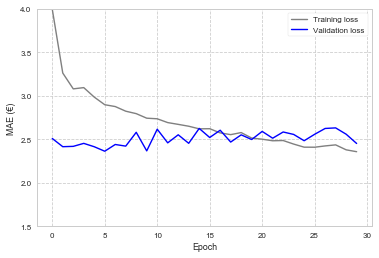

Checkpoint Ensembling

Training model # 2
Epoch 1/30
276/276 [==============================] - 298s 1s/step - loss: 0.3018 - mean_squared_error: 0.2368 - val_loss: 0.1891 - val_mean_squared_error: 0.0789
Epoch 2/30
276/276 [==============================] - 295s 1s/step - loss: 0.2492 - mean_squared_error: 0.1845 - val_loss: 0.1944 - val_mean_squared_error: 0.0772
Epoch 3/30
276/276 [==============================] - 295s 1s/step - loss: 0.2426 - mean_squared_error: 0.1855 - val_loss: 0.1996 - val_mean_squared_error: 0.0796
Epoch 4/30
276/276 [==============================] - 295s 1s/step - loss: 0.2312 - mean_squared_error: 0.1596 - val_loss: 0.2055 - val_mean_squared_error: 0.0857
Epoch 5/30
276/276 [==============================] - 295s 1s/step - loss: 0.2276 - mean_squared_error: 0.1560 - val_loss: 0.1919 - val_mean_squared_error: 0.0788
Epoch 6/30
276/276 [==============================] - 295s 1s/step - loss: 0.2218 - mean_squared_error: 0.1625 - val_loss: 0.1917 - val_mean_sq

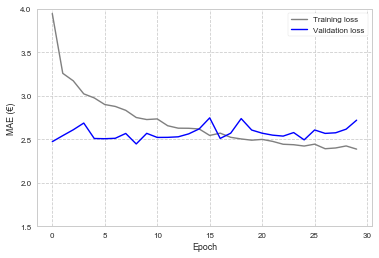

Checkpoint Ensembling

Training model # 3
Epoch 1/30
276/276 [==============================] - 290s 1s/step - loss: 0.3052 - mean_squared_error: 0.2699 - val_loss: 0.2077 - val_mean_squared_error: 0.0940
Epoch 2/30
276/276 [==============================] - 289s 1s/step - loss: 0.2484 - mean_squared_error: 0.1814 - val_loss: 0.1968 - val_mean_squared_error: 0.0804
Epoch 3/30
276/276 [==============================] - 296s 1s/step - loss: 0.2372 - mean_squared_error: 0.1705 - val_loss: 0.2018 - val_mean_squared_error: 0.0816
Epoch 4/30
276/276 [==============================] - 296s 1s/step - loss: 0.2323 - mean_squared_error: 0.1629 - val_loss: 0.2048 - val_mean_squared_error: 0.0850
Epoch 5/30
276/276 [==============================] - 296s 1s/step - loss: 0.2306 - mean_squared_error: 0.1694 - val_loss: 0.1817 - val_mean_squared_error: 0.0711
Epoch 6/30
276/276 [==============================] - 296s 1s/step - loss: 0.2210 - mean_squared_error: 0.1477 - val_loss: 0.1876 - val_mean_sq

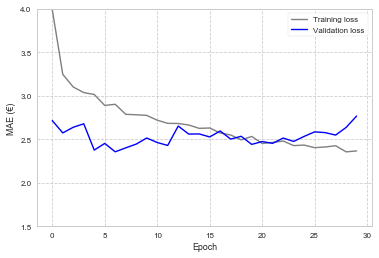

Checkpoint Ensembling

Training model # 4
Epoch 1/30
276/276 [==============================] - 291s 1s/step - loss: 0.3018 - mean_squared_error: 0.2446 - val_loss: 0.1861 - val_mean_squared_error: 0.0748
Epoch 2/30
276/276 [==============================] - 289s 1s/step - loss: 0.2513 - mean_squared_error: 0.2089 - val_loss: 0.1857 - val_mean_squared_error: 0.0753
Epoch 3/30
276/276 [==============================] - 288s 1s/step - loss: 0.2341 - mean_squared_error: 0.1631 - val_loss: 0.1801 - val_mean_squared_error: 0.0711
Epoch 4/30
276/276 [==============================] - 289s 1s/step - loss: 0.2313 - mean_squared_error: 0.1596 - val_loss: 0.1824 - val_mean_squared_error: 0.0734
Epoch 5/30
276/276 [==============================] - 289s 1s/step - loss: 0.2217 - mean_squared_error: 0.1443 - val_loss: 0.1831 - val_mean_squared_error: 0.0697
Epoch 6/30
276/276 [==============================] - 288s 1s/step - loss: 0.2218 - mean_squared_error: 0.1490 - val_loss: 0.1822 - val_mean_sq

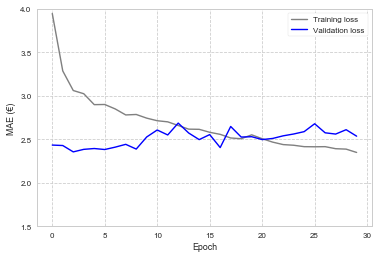

Checkpoint Ensembling

Training model # 5
Epoch 1/30
276/276 [==============================] - 322s 1s/step - loss: 0.3043 - mean_squared_error: 0.2581 - val_loss: 0.1816 - val_mean_squared_error: 0.0740
Epoch 2/30
276/276 [==============================] - 319s 1s/step - loss: 0.2505 - mean_squared_error: 0.1935 - val_loss: 0.2006 - val_mean_squared_error: 0.0824
Epoch 3/30
276/276 [==============================] - 321s 1s/step - loss: 0.2379 - mean_squared_error: 0.1708 - val_loss: 0.1790 - val_mean_squared_error: 0.0716
Epoch 4/30
276/276 [==============================] - 325s 1s/step - loss: 0.2313 - mean_squared_error: 0.1691 - val_loss: 0.1934 - val_mean_squared_error: 0.0788
Epoch 5/30
276/276 [==============================] - 319s 1s/step - loss: 0.2264 - mean_squared_error: 0.1661 - val_loss: 0.1779 - val_mean_squared_error: 0.0697
Epoch 6/30
276/276 [==============================] - 320s 1s/step - loss: 0.2212 - mean_squared_error: 0.1464 - val_loss: 0.1825 - val_mean_sq

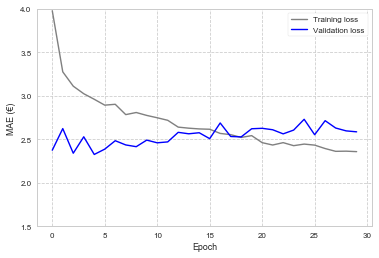

Checkpoint Ensembling


In [15]:
K.clear_session()

modelnum = 'lstm_1'
path = 'Results - Valid/LSTM_1/'
layer_x = Input(shape = (lookback+1, df2n.shape[-1]-1))

results_1 = evaluate_mlp(lstm_1, layer_x, train_gen, train_steps, stdevs, val_gen, val_steps, test_gen, test_steps,
                         path, k = 5, epochs = 30, ce_k = 5)

In [17]:
# Print the 10 best epochs for each model so we can manually delete the other weights
for i in range(5):
    print(results_1["val_ranked_epochs"][i][0:10])

[ 6 10  5  2  3  8  7 30  4 14]
[ 9  1 25  6  5 17  7 11 12 13]
[ 7  5  8 12 20  9  6 22 11 21]
[ 3  6  4  9  5 17  7  2  1  8]
[ 5  3  1  6  9  8 11 12  7 10]


In [8]:
lookback = 21*24
batch_size = 128

val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)

val_steps = ((train_size+valid_size) - (train_size+1) - lookback) // batch_size
test_steps = (len(df2n) - (train_size+valid_size+1) - lookback) // batch_size

path = 'Results - Valid/LSTM_1/'
layer_x = Input(shape = (lookback+1, df2n.shape[-1]-1))

evaluate_results(lstm_1, path)

VALIDATION
+-------+--------------+---------------+------------+-------------+
| Model | Min. MAE (€) | Ass. RMSE (€) | CE MAE (€) | CE RMSE (€) |
+-------+--------------+---------------+------------+-------------+
|   1   |    2.3620    |     3.4672    |   2.2765   |    3.3728   |
|   2   |    2.4457    |     3.5324    |   2.3361   |    3.4574   |
|   3   |    2.3553    |     3.4757    |   2.2829   |    3.3613   |
|   4   |    2.3545    |     3.4842    |   2.2416   |    3.3471   |
|   5   |    2.3249    |     3.4516    |   2.2475   |    3.3809   |
+-------+--------------+---------------+------------+-------------+
Ensembling across
MAE  (€): 2.2464
RMSE (€): 3.3544

TEST
+-------+----------+-----------+------------+-------------+
| Model |  MAE (€) |  RMSE (€) | CE MAE (€) | CE RMSE (€) |
+-------+----------+-----------+------------+-------------+
|   1   |  2.8084  |   4.3270  |   2.7414   |    4.2589   |
|   2   |  2.8278  |   4.3563  |   2.7421   |    4.2803   |
|   3   |  2.7772  

## LSTM 2: Bidirectional
- 7 days

In [9]:
def lstm_2(input_layer):
    layer_1 = layers.Bidirectional(layers.LSTM(512, dropout = 0.4, recurrent_dropout = 0.4,
                                   kernel_initializer = 'glorot_normal', return_sequences = True), 
                                   merge_mode = 'concat', input_shape = (lookback+1, df2n.shape[-1]-1))(input_layer)
    layer_2 = layers.LSTM(256, dropout = 0.4, recurrent_dropout = 0.4, kernel_initializer = 'glorot_normal')(layer_1)
    
    output_layer = layers.Dense(1)(layer_2)

    model = Model(input_layer, output_layer)
    
    return model

**Evaluate Train vs. Validation**  
Train 5 models with different random weight initializations so that we can take the median performance for a more reliable estimate of model performance. For each model, return the MAE and RMSE on the validation data. Also use the five best checkpoints (i.e. weights of the five lowest validation losses during training) to make a checkpoint ensemble, and return the resulting validation set MAE and RMSE.

In [10]:
lookback = 7*24
batch_size = 128

train_gen = generator(df2n, lookback=lookback, max_index=train_size, shuffle=True, batch_size=batch_size)
val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)

train_steps = (train_size - lookback) // batch_size
val_steps = ((train_size+valid_size) - (train_size+1) - lookback) // batch_size
test_steps = (len(df2n) - (train_size+valid_size+1) - lookback) // batch_size


Training model # 1
Epoch 1/30
279/279 [==============================] - 284s 1s/step - loss: 0.3018 - mean_squared_error: 0.2522 - val_loss: 0.2057 - val_mean_squared_error: 0.1059
Epoch 2/30
279/279 [==============================] - 285s 1s/step - loss: 0.2519 - mean_squared_error: 0.1909 - val_loss: 0.2103 - val_mean_squared_error: 0.1038
Epoch 3/30
279/279 [==============================] - 284s 1s/step - loss: 0.2415 - mean_squared_error: 0.1801 - val_loss: 0.1884 - val_mean_squared_error: 0.0916
Epoch 4/30
279/279 [==============================] - 283s 1s/step - loss: 0.2324 - mean_squared_error: 0.1707 - val_loss: 0.1933 - val_mean_squared_error: 0.0924
Epoch 5/30
279/279 [==============================] - 276s 988ms/step - loss: 0.2263 - mean_squared_error: 0.1639 - val_loss: 0.1969 - val_mean_squared_error: 0.0886
Epoch 6/30
279/279 [==============================] - 269s 965ms/step - loss: 0.2201 - mean_squared_error: 0.1456 - val_loss: 0.2053 - val_mean_squared_error: 0.1

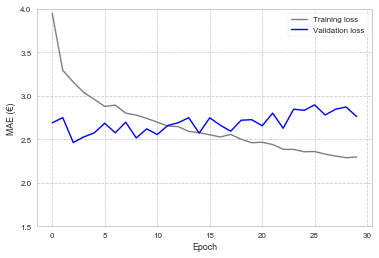

Checkpoint Ensembling

Training model # 2
Epoch 1/30
279/279 [==============================] - 273s 978ms/step - loss: 0.3044 - mean_squared_error: 0.2521 - val_loss: 0.1887 - val_mean_squared_error: 0.0954
Epoch 2/30
279/279 [==============================] - 270s 966ms/step - loss: 0.2517 - mean_squared_error: 0.1950 - val_loss: 0.2025 - val_mean_squared_error: 0.0984
Epoch 3/30
279/279 [==============================] - 270s 967ms/step - loss: 0.2423 - mean_squared_error: 0.1690 - val_loss: 0.2061 - val_mean_squared_error: 0.0994
Epoch 4/30
279/279 [==============================] - 270s 967ms/step - loss: 0.2336 - mean_squared_error: 0.1645 - val_loss: 0.1986 - val_mean_squared_error: 0.0977
Epoch 5/30
279/279 [==============================] - 270s 966ms/step - loss: 0.2291 - mean_squared_error: 0.1572 - val_loss: 0.2264 - val_mean_squared_error: 0.1325
Epoch 6/30
279/279 [==============================] - 270s 967ms/step - loss: 0.2199 - mean_squared_error: 0.1443 - val_loss: 0.

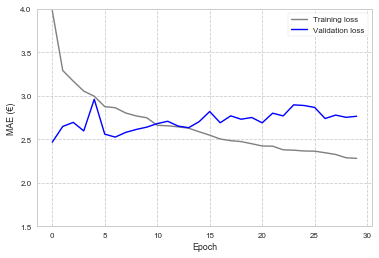

Checkpoint Ensembling

Training model # 3
Epoch 1/30
279/279 [==============================] - 272s 975ms/step - loss: 0.3061 - mean_squared_error: 0.2733 - val_loss: 0.1969 - val_mean_squared_error: 0.0993
Epoch 2/30
279/279 [==============================] - 268s 961ms/step - loss: 0.2515 - mean_squared_error: 0.1901 - val_loss: 0.1985 - val_mean_squared_error: 0.0957
Epoch 3/30
279/279 [==============================] - 268s 962ms/step - loss: 0.2393 - mean_squared_error: 0.1697 - val_loss: 0.1998 - val_mean_squared_error: 0.0967
Epoch 4/30
279/279 [==============================] - 268s 961ms/step - loss: 0.2307 - mean_squared_error: 0.1577 - val_loss: 0.2143 - val_mean_squared_error: 0.1055
Epoch 5/30
279/279 [==============================] - 268s 962ms/step - loss: 0.2312 - mean_squared_error: 0.1588 - val_loss: 0.2025 - val_mean_squared_error: 0.0942
Epoch 6/30
279/279 [==============================] - 268s 961ms/step - loss: 0.2195 - mean_squared_error: 0.1416 - val_loss: 0.

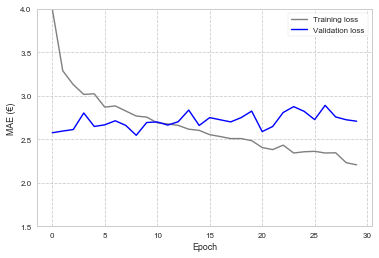

Checkpoint Ensembling

Training model # 4
Epoch 1/30
279/279 [==============================] - 302s 1s/step - loss: 0.3007 - mean_squared_error: 0.2439 - val_loss: 0.2194 - val_mean_squared_error: 0.1178
Epoch 2/30
279/279 [==============================] - 296s 1s/step - loss: 0.2526 - mean_squared_error: 0.1867 - val_loss: 0.2120 - val_mean_squared_error: 0.1059
Epoch 3/30
279/279 [==============================] - 296s 1s/step - loss: 0.2399 - mean_squared_error: 0.1720 - val_loss: 0.1960 - val_mean_squared_error: 0.0958
Epoch 4/30
279/279 [==============================] - 296s 1s/step - loss: 0.2341 - mean_squared_error: 0.1712 - val_loss: 0.2009 - val_mean_squared_error: 0.0976
Epoch 5/30
279/279 [==============================] - 297s 1s/step - loss: 0.2256 - mean_squared_error: 0.1508 - val_loss: 0.1972 - val_mean_squared_error: 0.0913
Epoch 6/30
279/279 [==============================] - 296s 1s/step - loss: 0.2217 - mean_squared_error: 0.1533 - val_loss: 0.1987 - val_mean_sq

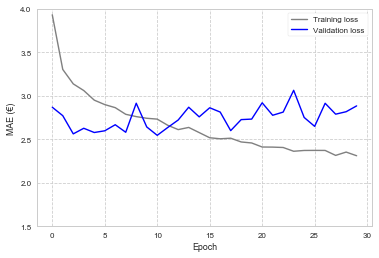

Checkpoint Ensembling

Training model # 5
Epoch 1/30
279/279 [==============================] - 327s 1s/step - loss: 0.2960 - mean_squared_error: 0.2281 - val_loss: 0.1947 - val_mean_squared_error: 0.0996
Epoch 2/30
279/279 [==============================] - 321s 1s/step - loss: 0.2493 - mean_squared_error: 0.1804 - val_loss: 0.1991 - val_mean_squared_error: 0.0996
Epoch 3/30
279/279 [==============================] - 321s 1s/step - loss: 0.2390 - mean_squared_error: 0.1715 - val_loss: 0.1945 - val_mean_squared_error: 0.0953
Epoch 4/30
279/279 [==============================] - 321s 1s/step - loss: 0.2351 - mean_squared_error: 0.1592 - val_loss: 0.2038 - val_mean_squared_error: 0.1023
Epoch 5/30
279/279 [==============================] - 321s 1s/step - loss: 0.2261 - mean_squared_error: 0.1518 - val_loss: 0.1951 - val_mean_squared_error: 0.0941
Epoch 6/30
279/279 [==============================] - 321s 1s/step - loss: 0.2203 - mean_squared_error: 0.1459 - val_loss: 0.1990 - val_mean_sq

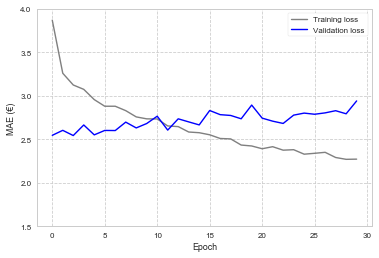

Checkpoint Ensembling


In [11]:
path = 'Results - Valid/LSTM_2/'
layer_x = Input(shape = (lookback+1, df2n.shape[-1]-1))

results_2 = evaluate_mlp(lstm_2, layer_x, train_gen, train_steps, stdevs, val_gen, val_steps, test_gen, test_steps,
                         path, k = 5, epochs = 30, ce_k = 5)

In [13]:
# Print the 10 best epochs for each model so we can manually delete the other weights
for i in range(5):
    print(results_2["val_ranked_epochs"][i][0:10])

[ 3  9  4 11 15  5  7 18 10 23]
[ 1  7  6  8  4  9 14 10  2 13]
[ 9  1 21  2  3 22  5 15  8 12]
[11  3  5  8  6 18  4 12 10 26]
[ 3  1  5  7  6  2 12  9  4 15]


In [11]:
lookback = 7*24
batch_size = 128

val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)

val_steps = ((train_size+valid_size) - (train_size+1) - lookback) // batch_size
test_steps = (len(df2n) - (train_size+valid_size+1) - lookback) // batch_size

path = 'Results - Valid/LSTM_2/'
layer_x = Input(shape = (lookback+1, df2n.shape[-1]-1))

evaluate_results(lstm_2, path)

VALIDATION
+-------+--------------+---------------+------------+-------------+
| Model | Min. MAE (€) | Ass. RMSE (€) | CE MAE (€) | CE RMSE (€) |
+-------+--------------+---------------+------------+-------------+
|   1   |    2.4622    |     3.9569    |   2.3826   |    3.7868   |
|   2   |    2.4663    |     4.0374    |   2.4263   |    3.8505   |
|   3   |    2.5453    |     3.9105    |   2.3819   |    3.7579   |
|   4   |    2.5448    |     3.9375    |   2.4589   |    3.8373   |
|   5   |    2.5423    |     4.0348    |   2.4168   |    3.8624   |
+-------+--------------+---------------+------------+-------------+
Ensembling across
MAE  (€): 2.3551
RMSE (€): 3.7617

TEST
+-------+----------+-----------+------------+-------------+
| Model |  MAE (€) |  RMSE (€) | CE MAE (€) | CE RMSE (€) |
+-------+----------+-----------+------------+-------------+
|   1   |  2.7471  |   4.3706  |   2.7223   |    4.3147   |
|   2   |  3.0154  |   4.6683  |   2.7663   |    4.3642   |
|   3   |  2.8510  